In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pathlib import Path
from argparse import Namespace
from collections import defaultdict
import matplotlib as plt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats

from scipy.stats import mstats

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# winsorize outliers !!!!
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
#         df[col] = mstats.winsorize(df[col], limits=[0.001, 0.001])
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #    df[col] = df[col].astype(np.float32)
                #else:
                df[col] = df[col].astype(np.float16)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:

#train = pd.read_csv('../input/ubiquant-market-prediction/train.csv')
train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

In [4]:
# Preprocess and winsorize !
train = reduce_mem_usage(train)


Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%


l=100
train=trains[trains['investment_id']<=l]
test=trains[(trains['investment_id']>l) & (trains['investment_id']<l+20)]
train.head()

In [5]:
import gc
gc.collect()
test_cols = ['investment_id']
feature = [c for c in train.columns if "f_" in c]
features = test_cols + feature


In [6]:
_ = train.pop("row_id")
_ = train.pop("time_id")

In [7]:
# train.head()

df=test
df['row_id']=((df['row_id']).str.strip())
#df['len']=pd.to_numeric((df['row_id']).str.len()-2)
df['row_id']=df['row_id'].apply(lambda x:x[0:x.find('_')])
df['time_id']=pd.to_numeric(df['row_id'])
test=df
test.drop('row_id',axis=1,inplace=True)

In [8]:

y = train.pop("target")
investment_id = train.pop("investment_id")

In [9]:
%%time
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

2022-03-14 15:26:56.940106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 15:26:57.070431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 15:26:57.071545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 15:26:57.075817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 865 ms, sys: 587 ms, total: 1.45 s
Wall time: 2.83 s


In [10]:
import tensorflow as tf
def preprocess(X, y):
    return X, y
def make_dataset(feature, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((feature), y))
    

    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(512, activation='swish')(features_inputs)
    feature_x = layers.Dense(512, activation='swish')(feature_x)
    feature_x = layers.Dense(515, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(feature_x)   # -> change this to feature_x
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x) 
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               154112    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 515)               264195    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               264192    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

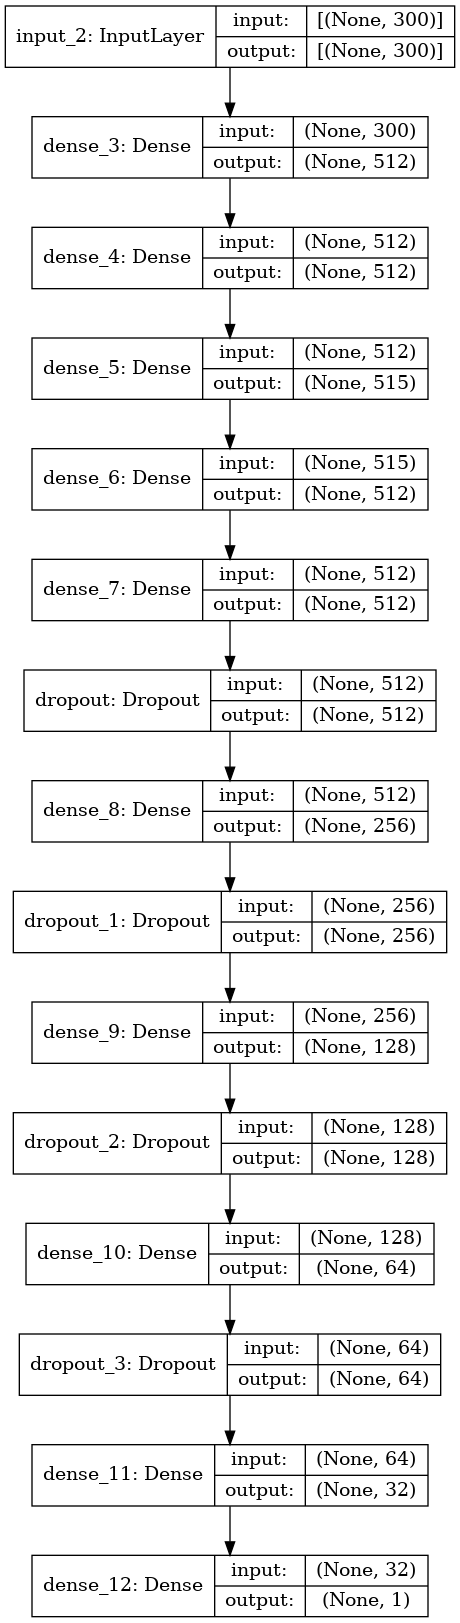

In [12]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [13]:
import gc
gc.collect()

5619

In [14]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train,investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    #investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    #investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, y_train)
    valid_ds = make_dataset(X_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    #pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    #print('Pearson:', pearson_score)
    #pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    #plt.title("MSE")
    #plt.show()
    #pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    #plt.title("MAE")
    #plt.show()
    #pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    #plt.title("RMSE")
    #plt.show()
    #del investment_id_train
    #del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break

2022-03-14 15:27:15.320229: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-03-14 15:27:16.850810: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-03-14 15:27:19.218435: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-03-14 15:27:20.140511: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.


Epoch 1/100
2455/2455 [==============================] - 22s 8ms/step - loss: 2.7624 - mse: 0.8379 - mae: 0.6268 - mape: 96709.6953 - rmse: 0.9154 - val_loss: 0.8560 - val_mse: 0.8371 - val_mae: 0.6290 - val_mape: 154870.8750 - val_rmse: 0.9149


2022-03-14 15:27:43.468756: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-03-14 15:27:44.971356: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.


Epoch 2/100
2455/2455 [==============================] - 16s 7ms/step - loss: 0.8423 - mse: 0.8352 - mae: 0.6261 - mape: 114088.4531 - rmse: 0.9139 - val_loss: 0.8394 - val_mse: 0.8354 - val_mae: 0.6291 - val_mape: 132740.7969 - val_rmse: 0.9140
Epoch 3/100
2455/2455 [==============================] - 16s 7ms/step - loss: 0.8367 - mse: 0.8325 - mae: 0.6252 - mape: 125150.0156 - rmse: 0.9124 - val_loss: 0.8374 - val_mse: 0.8339 - val_mae: 0.6280 - val_mape: 160339.0938 - val_rmse: 0.9132
Epoch 4/100
2455/2455 [==============================] - 16s 7ms/step - loss: 0.8346 - mse: 0.8308 - mae: 0.6245 - mape: 134486.4375 - rmse: 0.9115 - val_loss: 0.8364 - val_mse: 0.8332 - val_mae: 0.6276 - val_mape: 171211.8281 - val_rmse: 0.9128
Epoch 5/100
2455/2455 [==============================] - 16s 7ms/step - loss: 0.8331 - mse: 0.8296 - mae: 0.6240 - mape: 137977.9062 - rmse: 0.9108 - val_loss: 0.8356 - val_mse: 0.8327 - val_mae: 0.6277 - val_mape: 165560.9688 - val_rmse: 0.9125
Epoch 6/100
2455

In [15]:
def preprocess_test(feature):
    return (feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((feature)))
    ds = ds.map(preprocess_test)
    #ds = ds.batch(batch_size)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [16]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[feature], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [17]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("Completed at: ", now)


Completed at:  2022-03-14 15:42:40.223941
